# Introduction
i worked this project on an Anaconda navigator (using jypiter notebook)

In this competition, we are challenged to build a model that predicts the estimated time of arrival for Algerin ride hailing business Yassir
  
My current best submission is based on this script. My best model with these features reached LB 154.068144922 upon the clossing of competion on zindi plartform
 
With this simple notebook i  Explore the dataset
Extract  features

# Additional data
Additional dataset as given by zindi Weather_df i did not use it in this model:

# spliting train_test set
Create  70-30 train - test set with random_state 42

# model used 
Train simple CatBoostRegressor 

Analyze Feature Importance

Score test set and submit
 


In [3]:

#import all libraries to be used
!pip install catboost
import pandas as pd
import pylab as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import cluster
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn import pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
import os
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
%matplotlib inline
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor

     |████████████████████████████████| 64.8MB 60kB/s 


# Load data

In [5]:


# training data
training = pd.read_csv('/content/Train (3).csv')  
training['Timestamp'] = pd.to_datetime(training['Timestamp'])

# testing data
testing = pd.read_csv('/content/Test (2).csv') 
testing['Timestamp'] = pd.to_datetime(testing['Timestamp'])
# sample set submission
sample_set = pd.read_csv('/content/SampleSubmission (2).csv') 
 
    
# weather data
weather_df = pd.read_csv('/content/Weather.csv',parse_dates=['date'])
    

# EDA

In [6]:
#explore
training.head()       

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
0,000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784
1,000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576
2,001QSGIH,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526
3,002ACV6R,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130
4,0039Y7A8,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138


In [7]:
 testing.head()

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance
0,000V4BQX,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549
1,003WBC5J,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532
2,004O4X3A,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194
3,006CEI5B,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768
4,009G0M2T,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513


In [8]:
#data shape
print('We have {} training rows and {} test rows.'.format(training.shape[0], testing.shape[0]))
print('We have {} training columns and {} test columns.'.format(training.shape[1], testing.shape[1]))

We have 83924 training rows and 35625 test rows.
We have 8 training columns and 7 test columns.


In [9]:
#summary
training.describe()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
count,83924.000000,83924.000000,83924.000000,83924.000000,83924.000000,83924.000000
mean,3.052406,36.739358,3.056962,36.737732,13527.821410,1111.697762
std,0.096388,0.032074,0.100710,0.032781,9296.716006,563.565486
min,2.807000,36.589000,2.807000,36.596000,1.000000,1.000000
25%,2.994000,36.721000,2.995000,36.718000,6108.000000,701.000000
50%,3.046000,36.742000,3.049000,36.742000,11731.500000,1054.000000
75%,3.095000,36.760000,3.109000,36.760000,19369.000000,1456.000000
max,3.381000,36.820000,3.381000,36.819000,62028.000000,5238.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98ab353080>,
      dtype=object)

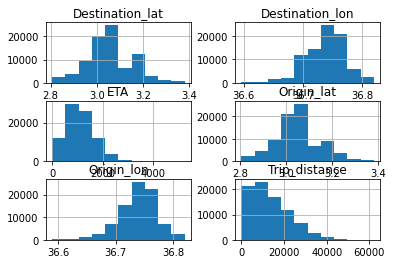

In [10]:
# checking how data is distributed
training.hist()

used hist function since data is small

## Feature Engineering

# 1. Datetime features extraction

from a Timestamp(time that the trip was taken) feature{date time} as given from the data  i extracted the following features 

> month_of_trip 
>year_of_trip
>day_of_trip
> hour_of_trip
>second_of_trip
>minute_of_trip
>week_of_year_trip
>weekday_of_trip
>week_of_trip
>weekday_of_trip

In [11]:
training['month_of_trip '] = training.Timestamp.dt.month
testing['month_of_trip '] = testing.Timestamp.dt.month
training['year_of_trip'] = training.Timestamp.dt.year 
testing['year_of_trip'] = testing.Timestamp.dt.year
training['day_of_trip'] = training.Timestamp.dt.day
testing['day_of_trip'] = testing.Timestamp.dt.day 
training['hour_of_trip'] = training.Timestamp.dt.hour
testing['hour_of_trip'] = testing.Timestamp.dt.hour
training['second_of_trip'] = training.Timestamp.dt.second
testing['second_of_trip'] = testing.Timestamp.dt.second
training['minute_of_trip'] = training.Timestamp.dt.minute
testing['minute_of_trip'] = testing.Timestamp.dt.minute
training.loc[:, 'week_of_trip'] = training['Timestamp'].dt.weekofyear
testing.loc[:, 'week_of_trip'] = testing['Timestamp'].dt.weekofyear
training.loc[:, 'weekday_of_trip'] = training['Timestamp'].dt.weekday
testing.loc[:, 'weekday_of_trip'] = testing['Timestamp'].dt.weekday
#review 
training.head(2)

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,month_of_trip,year_of_trip,day_of_trip,hour_of_trip,second_of_trip,minute_of_trip,week_of_trip,weekday_of_trip
0,000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784,12,2019,4,20,50,1,49,2
1,000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576,12,2019,10,22,9,37,50,1


# 2  longitude and latitude coordinates feature extraction

i use PCA to transform longitude and latitude coordinate

In [12]:
coords = np.vstack((training[['Origin_lat', 'Origin_lon']].values,
                    training[['Destination_lat', 'Destination_lon']].values,
                    testing[['Origin_lat', 'Origin_lon']].values,
                    testing[['Destination_lat', 'Destination_lon']].values))

pca = PCA().fit(coords)
training['pickup_pca0'] = pca.transform(training[['Origin_lat', 'Origin_lon']])[:, 0]
training['pickup_pca1'] = pca.transform(training[['Origin_lat', 'Origin_lon']])[:, 1]
training['destination_pca0'] = pca.transform(training[['Destination_lat', 'Destination_lon']])[:, 0]
training['destination_pca1'] = pca.transform(training[['Destination_lat', 'Destination_lon']])[:, 1]
testing['pickup_pca0'] = pca.transform(testing[['Origin_lat', 'Origin_lon']])[:, 0]
testing['pickup_pca1'] = pca.transform(testing[['Origin_lat', 'Origin_lon']])[:, 1]
testing['destination_pca0'] = pca.transform(testing[['Destination_lat', 'Destination_lon']])[:, 0]
testing['destination_pca1'] = pca.transform(testing[['Destination_lat', 'Destination_lon']])[:, 1]
#review
training.head(2)

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,month_of_trip,year_of_trip,day_of_trip,hour_of_trip,second_of_trip,minute_of_trip,week_of_trip,weekday_of_trip,pickup_pca0,pickup_pca1,destination_pca0,destination_pca1
0,000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784,12,2019,4,20,50,1,49,2,0.200315,-0.052565,-0.049894,0.024257
1,000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576,12,2019,10,22,9,37,50,1,0.034673,0.029310,0.027278,0.009783


#   clustering on coordinates

In [15]:
from sklearn.cluster import MiniBatchKMeans
from datetime import timedelta
import datetime as dt
np.random.seed(1987) #seed
N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()

In [16]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [17]:
training.loc[:, 'pickup_cluster'] = kmeans.predict(training[['Origin_lat', 'Origin_lon']])
training.loc[:, 'destination_cluster'] = kmeans.predict(training[['Destination_lat', 'Destination_lon']])
testing.loc[:, 'pickup_cluster'] = kmeans.predict(testing[['Origin_lat', 'Origin_lon']])
testing.loc[:, 'destination_cluster'] = kmeans.predict(testing[['Destination_lat', 'Destination_lon']])
t1 = dt.datetime.now()
print('Time till clustering: %i seconds' % (t1 - t0).seconds)

Time till clustering: 15 seconds


In [18]:
training.head(2)

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,month_of_trip,year_of_trip,day_of_trip,hour_of_trip,second_of_trip,minute_of_trip,week_of_trip,weekday_of_trip,pickup_pca0,pickup_pca1,destination_pca0,destination_pca1,pickup_cluster,destination_cluster
0,000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784,12,2019,4,20,50,1,49,2,0.200315,-0.052565,-0.049894,0.024257,84,5
1,000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576,12,2019,10,22,9,37,50,1,0.034673,0.029310,0.027278,0.009783,19,67


# modeling

In [ ]:
#evalution
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
y_train = training['ETA']
X_train = training.drop([ 'ID', 'Timestamp','ETA'], axis=1)
X_test = testing.drop([ 'ID', 'Timestamp'], axis=1)

In [ ]:
# creating train and test set
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [ ]:
model= CatBoostRegressor(iterations=5000)
model.fit(X_train_part, y_train_part)
model_valid_pred = model.predict(X_valid)
#In case   is forecasted negative
model_valid_pred[model_valid_pred < 0] = 0

Learning rate set to 0.023717
0:	learn: 553.8161447	total: 21.1ms	remaining: 1m 45s
1:	learn: 543.6257065	total: 40.1ms	remaining: 1m 40s
2:	learn: 533.6653976	total: 59.1ms	remaining: 1m 38s
3:	learn: 524.1209735	total: 77.9ms	remaining: 1m 37s
4:	learn: 514.8372770	total: 97.4ms	remaining: 1m 37s
5:	learn: 505.8401426	total: 116ms	remaining: 1m 36s
6:	learn: 496.9913455	total: 134ms	remaining: 1m 35s
7:	learn: 488.5910252	total: 152ms	remaining: 1m 35s
8:	learn: 480.1637903	total: 171ms	remaining: 1m 34s
9:	learn: 472.0511550	total: 196ms	remaining: 1m 38s
10:	learn: 464.0387582	total: 224ms	remaining: 1m 41s
11:	learn: 456.3808196	total: 257ms	remaining: 1m 46s
12:	learn: 448.8435579	total: 303ms	remaining: 1m 56s
13:	learn: 441.4475922	total: 341ms	remaining: 2m 1s
14:	learn: 434.3515337	total: 368ms	remaining: 2m 2s
15:	learn: 427.4929405	total: 394ms	remaining: 2m 2s
16:	learn: 420.6402895	total: 427ms	remaining: 2m 5s
17:	learn: 414.0122572	total: 459ms	remaining: 2m 6s
18:	lear

In [ ]:
rmse(y_valid, model_valid_pred)

134.6559340518229

In [ ]:
model_valid_pred = model.predict(X_test)

In [ ]:
 model_valid_pred

array([1384.171973  ,  788.37013912, 1058.26935783, ...,  655.66878027,
       1153.12939191,  611.3217558 ])

In [ ]:
#submission
sample_set['ETA'] = model_valid_pred
sample_set.to_csv('Bencmark_123456.csv',index = False)